In [1]:
import qutip
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import pickle
import time as timess
import math, cmath
import sys; import time as time
import auxiliary_library as me

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, formatter={"float":lambda x: str(.001*int(1000*x)) })

In [9]:
N = 6
spin_ops_list = me.one_body_spin_ops(N)

### Heisenberg Hamiltonian
chain_type = "XXX"; Hamiltonian_paras = [.2, .15, .1, 1.]
H_H = me.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                size = N, Hamiltonian_paras = Hamiltonian_paras,
                                closed_bcs = True, visualization = False)

### Basis operators 

cl_ops, label_ops = me.classical_ops(H_H, N, spin_ops_list, False)
magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
identity_op = spin_ops_list[0][0]

label_ops.append("magnetization"); label_ops.append("Neel_op"); 
cl_ops[label_ops[6]] = magnetization; cl_ops[label_ops[7]] = neel_operator; 

print("Are all the operators Hermitian?:", me.basis_hermitian_check(cl_ops))
cl_ops = me.Hamiltonian_comm_check(H_H, cl_ops, None, True)
cl_ops["identity"] = identity_op

# Note that this is not the initial state but, ideally, the final state. 

k_B = 1; temp = 5**10-2; x = .9
beta = 1/(k_B * temp)
rho_ref = (-beta * (1-x) * H_H - x * (cl_ops["n_oc_op"] - 1)**2).expm()
rho_ref = rho_ref/rho_ref.tr()

if (me.is_density_op(rho_ref)):
    pass
else:
    sys.exit("Not a valid density op")

### Chosen basis and operators ### ops=[id_glob, n_oc, n_oc**2, x, p , ac, comm, corr, H]

basis = [cl_ops["identity"], cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2, cl_ops["x_op"], cl_ops["p_op"], 
         cl_ops["p_dot"], cl_ops["comm_xp"], cl_ops["corr_xp"], cl_ops["Neel_op"], H_H]

basis_orth = me.base_orth(basis, rho_ref, me.HS_inner_prod_r, False)

### Evolution 

#phi0 = [0., .1, .1, 2., 1., -1., 1, .1, -2., .1]
phi0 = [0] + [np.random.rand() for i in range(len(basis_orth)-1)]
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()
phi0[0] = np.log(rho0.tr())
rho0 = (-sum( f*op for f,op in zip(phi0, basis_orth))).expm()

if (me.is_density_op(rho0)):
    pass
else:
    sys.exit("Not a valid density op")

Are all the operators Hermitian?: True
[H,  x_op ] = 0?:  False
[H,  p_op ] = 0?:  False
[H,  n_oc_op ] = 0?:  False
[H,  comm_xp ] = 0?:  False
[H,  corr_xp ] = 0?:  False
[H,  p_dot ] = 0?:  False
[H,  magnetization ] = 0?:  True
magnetization basis element deleted
[H,  Neel_op ] = 0?:  False


In [10]:
for i in range(len(basis_orth)):
    print("<Op[",i, "] rho0> ", qutip.expect(basis_orth[i], rho0))

<Op[ 0 ] rho0>  1.0
<Op[ 1 ] rho0>  0.38572983299664426
<Op[ 2 ] rho0>  0.05530154541077323
<Op[ 3 ] rho0>  0.3739198992903364
<Op[ 4 ] rho0>  -0.5743359287880565
<Op[ 5 ] rho0>  -0.13453962359521932
<Op[ 6 ] rho0>  -0.6917038849134202
<Op[ 7 ] rho0>  -0.3833866183424153
<Op[ 8 ] rho0>  -0.5208975291254467
<Op[ 9 ] rho0>  -0.6671048893822182


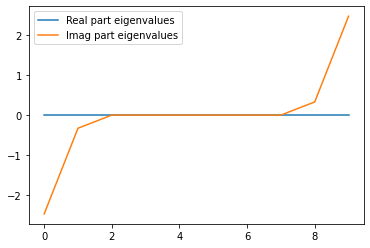

In [11]:
Hijtensor = np.array(me.H_ij_matrix(H_H, basis_orth, rho_ref, me.HS_inner_prod_r)[1])
plt.plot(qutip.Qobj(Hijtensor).eigenenergies().real, label = "Real part eigenvalues")
plt.plot(sorted(qutip.Qobj(Hijtensor).eigenenergies().imag), label = "Imag part eigenvalues")

plt.legend()

# Exact solution using semigroups

In [15]:
ts1 = np.linspace(0, 200, 500)
Phi_vector_solution = []
Phi_vector_solution.append(np.array(phi0))

for i in range(len(ts1)-1):
    a = ( ts1[i+1] * qutip.Qobj(Hijtensor) ).expm() * Phi_vector_solution[0]
    Phi_vector_solution.append(a)
    
rho_at_timet = []
rho_at_timet.append(rho0)

for i in range(len(Phi_vector_solution)):
    rhot= (-sum( f*op for f,op in zip(Phi_vector_solution[i], basis_orth))).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet.append(rhot)

for t in range(len(rho_at_timet)):
    if not me.is_density_op(rho_at_timet[t]):
        print("At time", t, "not density op")
        #rho_at_timet[t] = .5 * (rho_at_timet[t] + rho_at_timet[t].dag())
        #print("Moddified accordingly")

At time 5 not density op
At time 6 not density op
At time 13 not density op
At time 14 not density op
At time 15 not density op
At time 16 not density op
At time 17 not density op
At time 18 not density op
At time 19 not density op
At time 20 not density op
At time 21 not density op
At time 22 not density op
At time 23 not density op
At time 24 not density op
At time 25 not density op
At time 26 not density op
At time 27 not density op
At time 28 not density op
At time 29 not density op
At time 30 not density op
At time 31 not density op
At time 32 not density op
At time 33 not density op
At time 34 not density op
At time 35 not density op
At time 36 not density op
At time 37 not density op
At time 38 not density op
At time 39 not density op
At time 40 not density op
At time 41 not density op
At time 42 not density op
At time 43 not density op
At time 44 not density op
At time 45 not density op
At time 46 not density op
At time 47 not density op
At time 48 not density op
At time 49 not

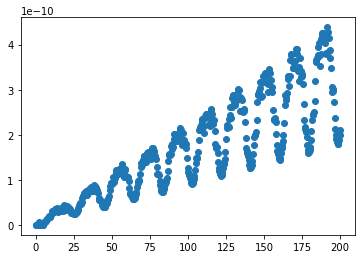

In [16]:
non_densitiness = []
for i in range(len(rho_at_timet)-1):
    non_densitiness.append(linalg.norm(linalg.norm(rho_at_timet[i] - rho_at_timet[i].dag())/(linalg.norm(rho_at_timet[i]))))
    
plt.scatter(ts1, non_densitiness)

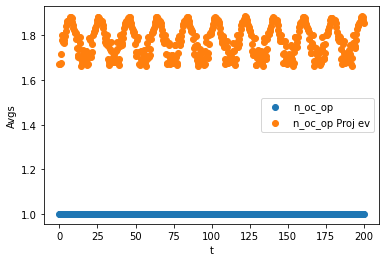

In [17]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
for index, name in enumerate(["n_oc_op"]):
    plt.scatter(res.times, res.expect[index], label = name)

plt.scatter(ts1, (qutip.expect(cl_ops["n_oc_op"], rho_at_timet)[:-1]), label = "n_oc_op Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


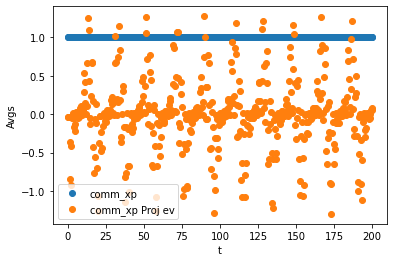

In [18]:
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
for index, name in enumerate(["comm_xp"]):
    plt.scatter(res.times, res.expect[index], label = name)

plt.scatter(ts1, (qutip.expect(cl_ops["comm_xp"], rho_at_timet)[:-1]), label = "comm_xp Proj ev")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


In [19]:
me.bures(rho_ref, rho0)

0.22817484424873755

In [20]:
me.bures(rho_ref, rho_at_timet[500])
#rho_ref = (-.1 * H_H -.9 * (cl_ops["n_oc_op"] - cl_ops["Neel_op"])**2).expm()# .5*(cl_ops["n_oc_op"])**2).expm()


SystemExit: Singular input matrix

C:\Users\tomas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Numerical Solution with ODEINT

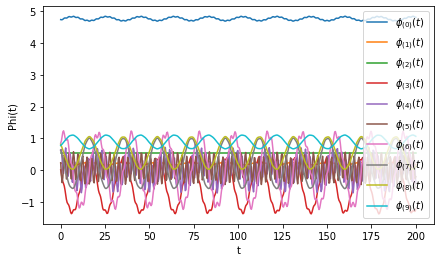

In [22]:
from scipy.integrate import odeint
import random

def F(y, t, H_tensor):
    return H_tensor.dot(y)

ts1 = np.linspace(0, 200, 500)
result = odeint(func=F, y0=phi0,t=ts1,args=(np.real(Hijtensor),))
plt.figure(figsize=(7, 4))

for i in range(len(basis)):
    plt.plot(ts1, result[:,i], label=r'$\phi_{(%d)}(t)$'%i)

plt.xlabel("t")
plt.ylabel("Phi(t)")
plt.legend()

C:\Users\tomas\anaconda3\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


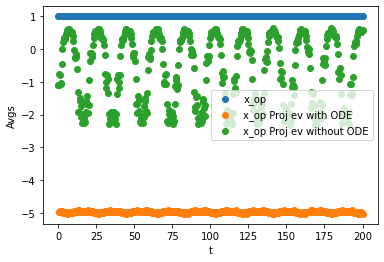

In [23]:
rho_at_timet_exact_ode = [rho0]

for t in range(len(ts1)):
    loc_K = sum([result[:,i][t] * basis_orth[i] for i in range(len(basis_orth))])
    rhot = (loc_K).expm()
    rhot = rhot/rhot.tr()
    rho_at_timet_exact_ode.append(rhot)
    loc_K = 0
    
res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
for index, name in enumerate(["x_op"]):
    plt.scatter(res.times, res.expect[index], label = name)

plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet_exact_ode )[:-1]), label = "x_op Proj ev with ODE")
plt.scatter(ts1, (qutip.expect(cl_ops["x_op"], rho_at_timet)[:-1]), label = "x_op Proj ev without ODE")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

# Spin chain exact evolution 

In [24]:
start_time = time.time()
unitary_ev = True; gamma = None; size = N; gaussian = None; gr = None; xng = None
chain_types = "XXX"; Hamiltonian_paras = [.2, .15, .1, 1.]
obs_basis = basis; ts = np.linspace(0,200,850)

title, ev_paras, resultsB = me.spin_chain_ev(closed_bcs = True, size = size, init_state = rho0, chain_type = chain_types, 
                                             Hamiltonian_paras = Hamiltonian_paras, omega_1=3., omega_2=3., 
                                             temp=1, tmax = 200, deltat = 1, two_body_basis = True, 
                                             unitary_ev = unitary_ev, gamma = gamma, gaussian = gaussian, 
                                             gr = gr, xng = xng, sc_prod = me.HS_inner_prod_r, obs_basis = basis, 
                                             do_project = False)

print("--- %s seconds ---" % (time.time() - start_time))

ev_paras["Time elapsed"] = time.time() - start_time

Processing custom initial state
Processing custom observable basis
sampling: 30
Closed evolution chosen
--- 3.5528595447540283 seconds ---


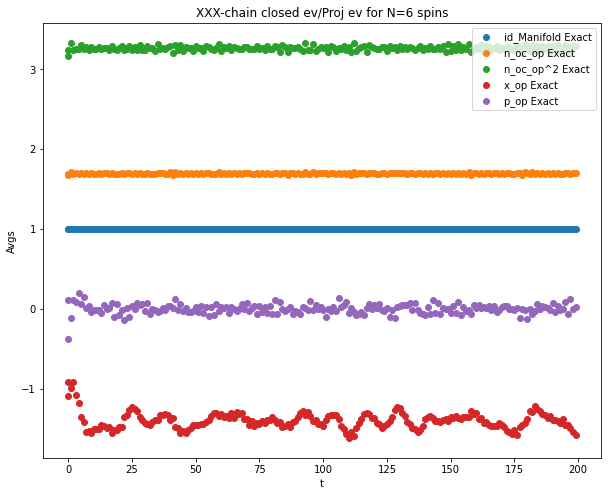

In [25]:
plot_labels1 = ["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"] 
plot_labels2 = ["p_dot", "comm_xp", "corr_xp", "Neel_op", "H"]

plt.figure(figsize=(10, 8))

for n in range(len(plot_labels1)):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels1[n] + " Exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

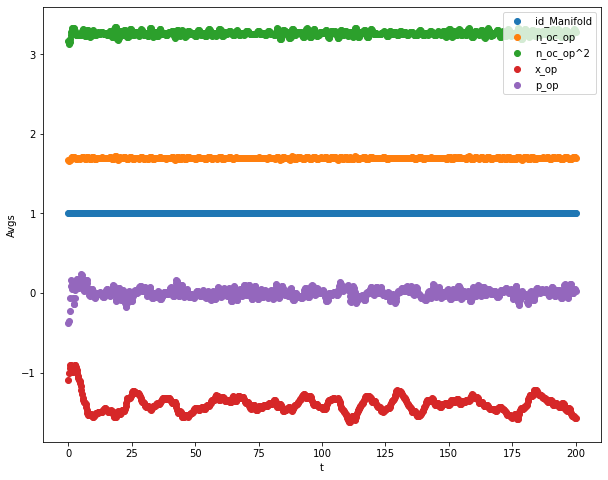

In [26]:
### dinÃƒÂ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["id_Manifold", "n_oc_op", "n_oc_op^2", "x_op", "p_op"]): #+ ["p_dot", "comm_xp", "corr_xp", "Neel_op","H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()


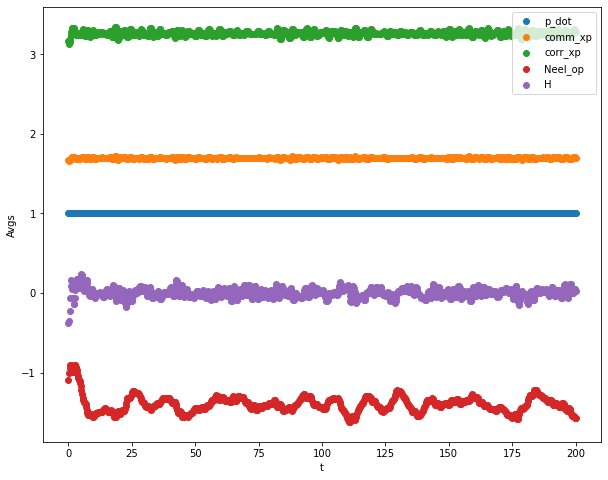

In [27]:
### dinÃƒÂ¡mica 

res=qutip.mesolve(H_H, rho0, np.linspace(0,200,850), c_ops=None, e_ops=basis)
plt.figure(figsize=(10, 8))

for index, name in enumerate(["p_dot", "comm_xp", "corr_xp", "Neel_op","H"]):
    plt.scatter(res.times, res.expect[index], label = name)
    
plt.xlabel("t")
plt.ylabel("Avgs")
plt.legend()

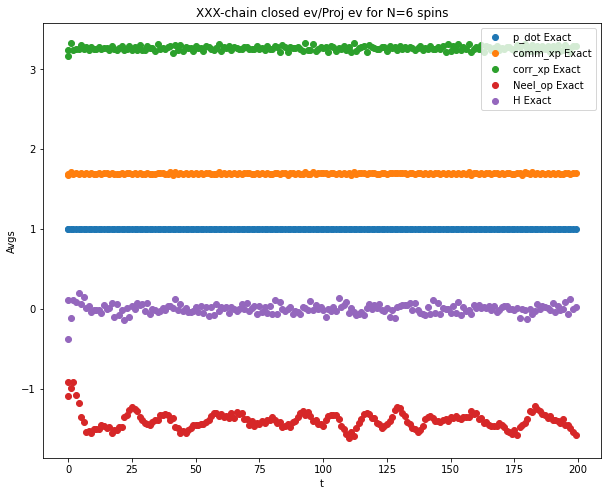

In [28]:
plt.figure(figsize=(10, 8))

for n in range(len(plot_labels2)):
    plt.scatter(resultsB["ts"], resultsB["averages"][:,n], label=plot_labels2[n] + " Exact")

plt.xlabel("t")
plt.ylabel("Avgs")
plt.title(title)
plt.legend()

In [28]:
nabla_t = [[0, -1, 1, 0, 0, 0], [-1, 0, 1, 0, 0, 0], [-1, 1, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, -1], [0,0,0, 1, 0, -1], [0,0,0, 1, -1, 0]]
qutip.Qobj(qutip.Qobj(nabla_t).eigenenergies())

Quantum object: dims = [[6], [1]], shape = (6, 1), type = ket
Qobj data =
[[-0.999]
 [-0.999]
 [0.0]
 [0.0]
 [0.999]
 [0.999]]